In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari
import joblib
import glob
import os
from IPython.display import display, Markdown

SZBINTY = pd.CategoricalDtype(truvari.SZBINS[1:], ordered=True)
ref_order = ["hg19", "grch38", "chm13"]
#sb.set('poster')

In [2]:
metadata = pd.read_csv("../metadata/sample_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [3]:
data = joblib.load("../stats/indiv_stats.jl")
#weird_sample = data["sample"] == "NA18939"
#data = data[~weird_sample & ~(data["merge"].str.startswith("removed"))]
redund_samples = ["HG00733", "NA12878", "NA24385"]
pr1 = data["reference"] == 'pr1'
data = data[~((data["sample"].isin(redund_samples)) & (data["project"] == "eichler")) & ~pr1]

In [32]:
data['ancestry'] = data['sample'].map(metadata['Superpopulation code'])
data['is_afr'] = data['ancestry'] == 'AFR'
data[data['merge'] == 'exact'].groupby(['sample', 'is_afr', 'reference']).size().reset_index().groupby(['is_afr']).mean()

,0
is_afr,
False,25598.213333
True,30801.000000


In [4]:
def plot_sv_counts(m_data, base_fn=None):
    """
    Creates a view of the data by reference/sample/project and by svtype with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], len(subdat)])
        subdat["count"] = 1
        tygrp = subdat.groupby(["svtype"]).sum()["count"]
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "DEL", tygrp.loc["DEL"]])
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "INS", tygrp.loc["INS"]])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "svcount"])
    ho = sorted(list(view["Superpopulation"].unique()))
    print(ho)
    p = sb.catplot(data=view, x="reference", y="svcount", hue="Superpopulation", order=ref_order, hue_order=ho)
    p.legend.remove()
    p.set(title="SV Counts", xlabel="", ylabel="")
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Pop.")
    if base_fn:
        ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.ax.get_yticks()/1000]
        p.set_yticklabels(ylabels)
        #plt.xticks(rotation=45)
        plt.savefig(base_fn + "_counts", transparent=True)
    plt.show()
    
    
    p = sb.catplot(data=view_bytype, x="svtype", y="svcount", hue="Superpopulation", col="reference", col_order=ref_order)
    #p.set(title="SV Counts per-sample by reference/SVTYPE", xlabel="Reference", ylabel="Count")
    p.fig.subplots_adjust(top=0.9) 
    hide = p.fig.suptitle('SV Counts per-sample by reference/SVTYPE')
    if base_fn:
        plt.savefig(base_fn + "_counts_type", transparent=True)
    plt.show()
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference"]).describe())
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view_bytype.groupby(["reference", "svtype"]).describe())

    return view, view_bytype
    
def plot_svsize_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by sizebin with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        for size, subdat2 in subdat.groupby("szbin"):
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], size, len(subdat2)])
        for idx2, subdat2 in subdat.groupby(["svtype", "szbin"]):
            svtype, szbin = idx2        
            view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], svtype, szbin, len(subdat2)])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "szbin", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "szbin", "svcount"])
    p = sb.barplot(data=view, x="szbin", y="svcount", order=truvari.SZBINS[1:], hue="reference", hue_order=ref_order)
    p.set(title=f"SV count by SV size")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    p = sb.catplot(data=view_bytype, kind="bar", x="szbin", y="svcount", col="reference", hue="svtype", col_order=ref_order)
    [plt.setp(ax.get_xticklabels(), rotation=45, ha="right") for ax in p.axes.flat]
    p.fig.subplots_adjust(top=0.9) 
    hide = p.fig.suptitle('SV count by SV size/type per-reference')
    plt.show()
    view["szbin"] = view["szbin"].astype(SZBINTY)
    view_bytype["szbin"] = view_bytype["szbin"].astype(SZBINTY)
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference", "szbin"]).describe())
        display(view_bytype.groupby(["reference", "svtype", "szbin"]).describe())

    return view, view_bytype

def plot_hethom_stats(m_data):
    """
    Creates a view of the data by reference/sample/project and summarizes the GT counts and ratios
    Creates a plot, also
    Return the data view
    """
    view = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        subdat["count"] = 1
        gtgrp = subdat.groupby(["GT"]).sum()["count"]    
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "TOT", gtgrp.loc["HET"], gtgrp.loc["HOM"]])
        for idx2, subdat2 in subdat.groupby(["svtype"]):
            if idx2 not in ["DEL", "INS"]: continue
            gtgrp = subdat2.groupby(["GT"]).sum()["count"]   
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], idx2, gtgrp.loc["HET"], gtgrp.loc["HOM"]])
    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svtype", "HET", "HOM"])
    view["Ratio"] = view["HET"] / view["HOM"]

    p = sb.catplot(data=view[view["svtype"] == "TOT"], x="reference", y="Ratio", hue="Superpopulation", order=ref_order)
    p.set(title="Het/Hom ratio per-sample by reference", xlabel="Reference", ylabel="Het/Hom Ratio")
    plt.show()
    
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(view.groupby(["reference", "svtype"])["Ratio"].describe())
    return view

First, let's look at just the generic "strict" strategy's numbers

# Strict Merging - Per-Sample Stats

## SVCounts per-sample

['AFR', 'AMR', 'EAS', 'EUR', 'SAS']


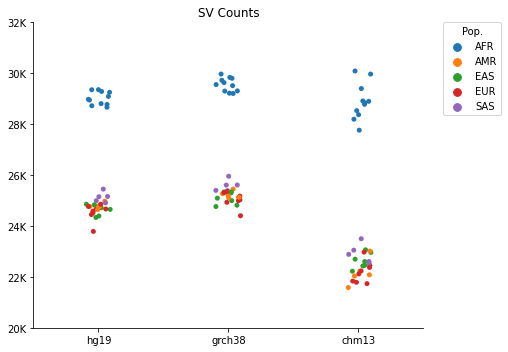

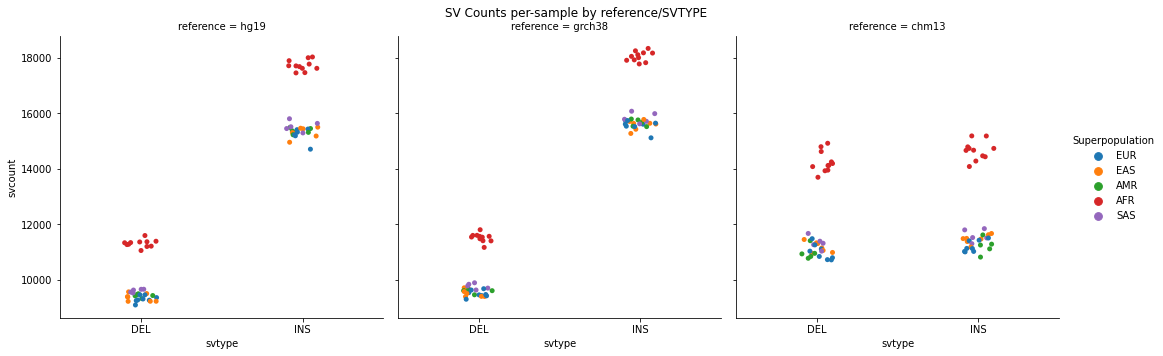

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 24,423 3,054 21,581 22,231 22,792 28,240 30,090
grch38         36 26,534 2,052 24,403 25,126 25,350 29,240 29,971
hg19           36 26,048 2,023 23,787 24,669 24,856 28,738 29,357

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 12,062 1,494 10,711 10,971 11,305 13,929 14,914
          INS         36 12,361 1,566 10,812 11,270 11,501 14,312 15,179
grch38    DEL         36 10,162   919  9,293  9,489  9,668 11,397 11,798
          INS         36 16,371 1,141 15,110 15,607 15,728 17,840 18,332
hg19      DEL         36  9,981   901  9,086  9,343  9,494 11,197 11,589
          INS         36 16,067 1,129 14,701 15,313 15,444 17,499 18,024

## SVCounts by SZBIN per-sample

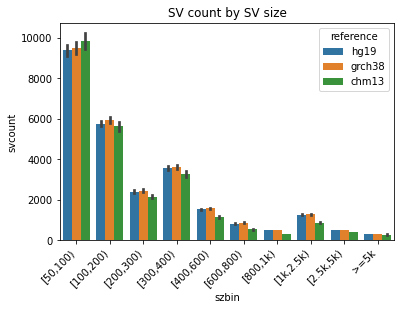

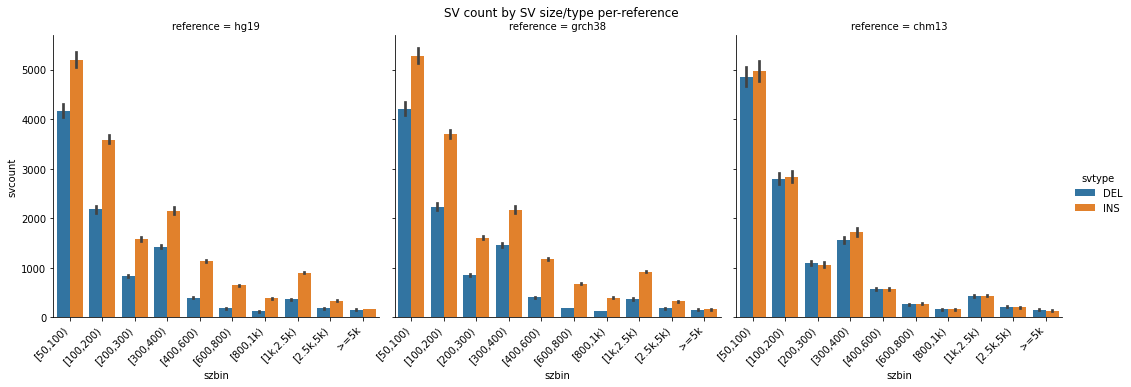

svcount                                            
                      count  mean   std   min   25%   50%    75%    max
reference szbin                                                        
chm13     [50,100)       36 9,816 1,214 8,710 8,977 9,141 11,352 11,943
          [100,200)      36 5,622   711 4,949 5,116 5,254  6,477  6,956
          [200,300)      36 2,151   261 1,858 1,968 2,020  2,455  2,721
          [300,400)      36 3,273   458 2,849 2,928 3,032  3,810  4,255
          [400,600)      36 1,143   127   943 1,054 1,091  1,306  1,375
          [600,800)      36   535    75   448   479   508    609    721
          [800,1k)       36   319    39   260   291   306    354    408
          [1k,2.5k)      36   869   111   750   787   822    993  1,057
          [2.5k,5k)      36   412    54   345   372   395    468    521
          >=5k           36   283    36   226   256   272    318    346
grch38    [50,100)       36 9,482   831 8,711 8,911 9,016 10,594 10,892
          [100,200)      36 5,923   464 5,417 5,604 5,684  6,549  6,707
          [200,300)      36 2,445   169 2,230 2,332 2,375  2,620  2,754
          [300,400)      36 3,626   312 3,339 3,402 3,444  4,042  4,229
          [400,600)      36 1,579    87 1,465 1,508 1,558  1,656  1,757
          [600,800)      36   859    54   789   816   844    913    964
          [800,1k)       36   514    36   464   488   508    528    590
          [1k,2.5k)      36 1,285    79 1,176 1,226 1,258  1,383  1,422
          [2.5k,5k)      36   506    41   439   476   496    530    605
          >=5k           36   315    26   264   299   308    328    365
hg19      [50,100)       36 9,368   819 8,567 8,798 8,934 10,509 10,748
          [100,200)      36 5,760   455 5,209 5,453 5,520  6,377  6,541
          [200,300)      36 2,405   167 2,176 2,291 2,332  2,581  2,703
          [300,400)      36 3,565   307 3,299 3,349 3,390  3,964  4,148
          [400,600)      36 1,522    84 1,385 1,462 1,503  1,600  1,700
          [600,800)      36   827    55   754   789   805    884    941
          [800,1k)       36   504    34   457   480   497    530    582
          [1k,2.5k)      36 1,265    81 1,150 1,198 1,241  1,352  1,411
          [2.5k,5k)      36   515    39   451   488   511    536    613
          >=5k           36   316    25   269   301   311    331    363

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,853 599 4,295 4,446 4,545 5,589 5,959
                 [100,200)      36 2,792 357 2,386 2,534 2,614 3,230 3,429
                 [200,300)      36 1,087 130   939   996 1,032 1,236 1,344
                 [300,400)      36 1,553 184 1,373 1,426 1,462 1,748 1,964
                 [400,600)      36   564  68   485   510   538   630   708
                 [600,800)      36   263  39   189   234   250   302   351
                 [800,1k)       36   159  21   131   145   154   174   212
                 [1k,2.5k)      36   430  65   342   378   405   498   560
                 [2.5k,5k)      36   209  32   171   185   198   238   274
                 >=5k           36   152  20   115   139   146   169   192
          INS    [50,100)       36 4,963 619 4,372 4,525 4,640 5,754 5,987
                 [100,200)      36 2,830 357 2,466 2,586 2,637 3,239 3,527
                 [200,300)      36 1,064 134   918   966 1,002 1,208 1,377
                 [300,400)      36 1,720 275 1,476 1,517 1,571 2,038 2,291
                 [400,600)      36   579  65   444   543   563   634   712
                 [600,800)      36   272  40   218   246   259   304   371
                 [800,1k)       36   160  21   129   146   153   181   196
                 [1k,2.5k)      36   439  48   381   401   420   485   535
                 [2.5k,5k)      36   203  26   160   180   204   225   256
                 >=5k           36   131  19   105   116   124   146   168
grch38    DEL    [50,100)       36 4,212 393 3,795 3,927 4,014 4,680 4,872
                 [100,200)      36 2,230 216 1,995 2,084 2,121 2,516 2,596
                 [200,300)      36   845  75   755   788   818   917   992
                 [300,400)      36 1,456 109 1,322 1,380 1,402 1,592 1,648
                 [400,600)      36   406  36   351   380   398   429   489
                 [600,800)      36   187  23   153   170   184   209   228
                 [800,1k)       36   123  14   101   115   120   132   154
                 [1k,2.5k)      36   368  41   316   340   353   410   455
                 [2.5k,5k)      36   181  25   151   162   171   200   234
                 >=5k           36   155  15   130   146   152   161   184
          INS    [50,100)       36 5,271 444 4,795 4,967 5,020 5,829 6,054
                 [100,200)      36 3,693 252 3,408 3,517 3,570 4,008 4,140
                 [200,300)      36 1,600  97 1,442 1,539 1,566 1,702 1,767
                 [300,400)      36 2,170 206 1,970 2,027 2,065 2,432 2,581
                 [400,600)      36 1,173  57 1,088 1,125 1,164 1,206 1,300
                 [600,800)      36   672  35   619   644   666   696   748
                 [800,1k)       36   391  25   353   372   390   406   449
                 [1k,2.5k)      36   917  43   855   884   908   945 1,013
                 [2.5k,5k)      36   324  21   279   310   323   336   384
                 >=5k           36   160  14   132   149   162   169   187
hg19      DEL    [50,100)       36 4,166 386 3,754 3,888 3,974 4,664 4,834
                 [100,200)      36 2,176 210 1,959 2,032 2,080 2,449 2,542
                 [200,300)      36   828  73   746   772   800   895   982
                 [300,400)      36 1,420 105 1,289 1,346 1,368 1,554 1,598
                 [400,600)      36   392  37   335   362   385   420   480
                 [600,800)      36   182  23   152   162   174   202   231
                 [800,1k)       36   118  12    99   110   118   126   144
                 [1k,2.5k)      36   364  44   310   332   346   414   453
                 [2.5k,5k)      36   183  23   150   165   176   201   229
                 >=5k           36   154  15   130   144   152   159   186
          INS    [50,100)       36 5,202 437 4,710 4

## SV HET/HOM Ratios

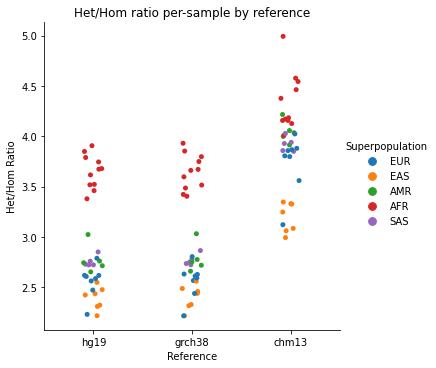

count  mean  std  min  25%  50%  75%  max
reference svtype                                           
chm13     DEL     36.00  3.54 0.42 2.68 3.42 3.58 3.78 4.53
          INS     36.00  4.28 0.52 3.26 4.08 4.28 4.58 5.52
          TOT     36.00  3.89 0.46 2.99 3.74 3.93 4.16 4.99
grch38    DEL     36.00  2.79 0.49 2.04 2.45 2.65 3.28 3.66
          INS     36.00  3.01 0.55 2.22 2.62 2.79 3.54 4.11
          TOT     36.00  2.92 0.52 2.21 2.56 2.74 3.44 3.93
hg19      DEL     36.00  2.80 0.49 2.06 2.47 2.65 3.31 3.67
          INS     36.00  3.00 0.56 2.24 2.61 2.77 3.56 4.06
          TOT     36.00  2.92 0.53 2.22 2.56 2.72 3.47 3.91

In [5]:
strict_data = data[(data["merge"] == "strict")]
display(Markdown("# Strict Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
strict_sv_counts = plot_sv_counts(strict_data, "./strict_persample")
display(Markdown("## SVCounts by SZBIN per-sample"))
strict_sz_counts = plot_svsize_counts(strict_data)
display(Markdown("## SV HET/HOM Ratios"))
strict_gt_counts = plot_hethom_stats(strict_data)

Then, we'll look at a comparison of the strategies and what it means for the truth set SV counts by comparing with 'exact' and 'loose' merges

# Exact Merging - Per-Sample Stats

## SVCounts per-sample

['AFR', 'AMR', 'EAS', 'EUR', 'SAS']


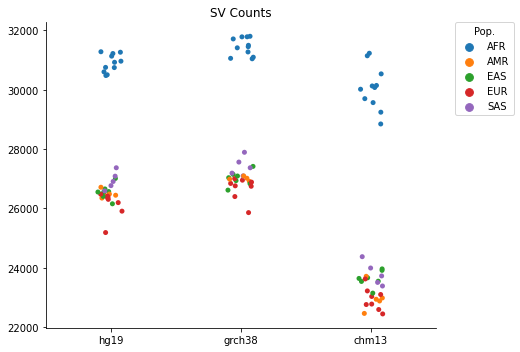

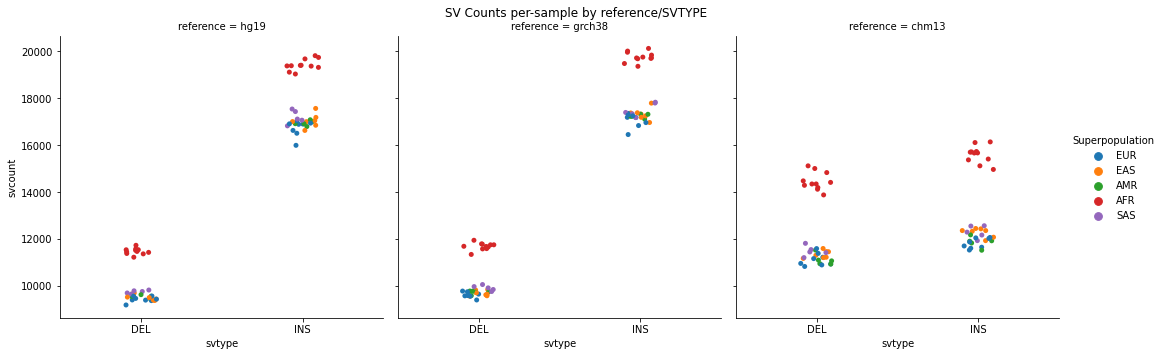

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 25,377 3,201 22,446 23,084 23,653 29,325 31,230
grch38         36 28,346 2,117 25,860 26,907 27,096 31,068 31,802
hg19           36 27,841 2,091 25,188 26,414 26,624 30,530 31,281

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 12,238 1,523 10,835 11,176 11,457 14,142 15,119
          INS         36 13,139 1,687 11,526 11,933 12,314 15,183 16,139
grch38    DEL         36 10,324   932  9,408  9,647  9,788 11,586 11,950
          INS         36 18,022 1,196 16,452 17,217 17,344 19,527 20,119
hg19      DEL         36 10,137   915  9,195  9,468  9,645 11,375 11,736
          INS         36 17,703 1,190 15,993 16,905 17,054 19,160 19,810

## SVCounts by SZBIN per-sample

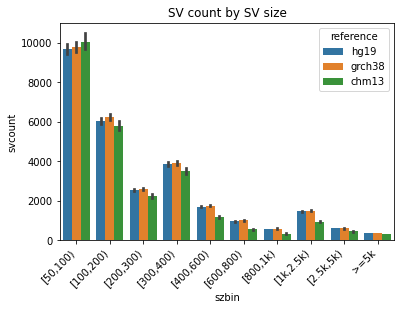

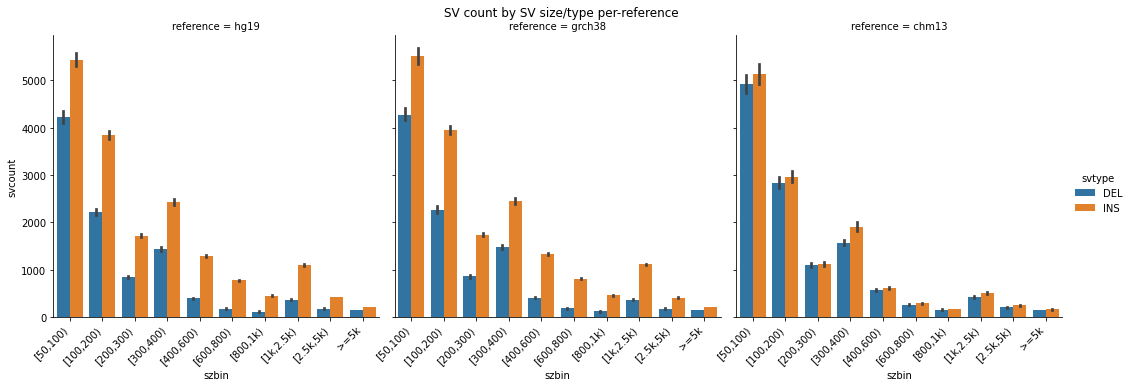

svcount                                             
                      count   mean   std   min   25%   50%    75%    max
reference szbin                                                         
chm13     [50,100)       36 10,050 1,249 8,937 9,201 9,380 11,618 12,217
          [100,200)      36  5,802   741 5,124 5,298 5,430  6,686  7,175
          [200,300)      36  2,232   273 1,911 2,046 2,095  2,551  2,806
          [300,400)      36  3,484   482 3,058 3,138 3,226  4,046  4,504
          [400,600)      36  1,190   132   980 1,098 1,134  1,355  1,437
          [600,800)      36    560    79   479   500   529    642    748
          [800,1k)       36    337    43   274   307   320    377    437
          [1k,2.5k)      36    941   127   808   846   885  1,083  1,158
          [2.5k,5k)      36    462    62   378   415   439    530    578
          >=5k           36    318    44   245   286   305    361    396
grch38    [50,100)       36  9,784   848 8,943 9,184 9,300 10,925 11,181
          [100,200)      36  6,233   476 5,642 5,900 5,979  6,849  7,028
          [200,300)      36  2,602   174 2,372 2,490 2,530  2,788  2,904
          [300,400)      36  3,927   317 3,599 3,711 3,739  4,346  4,527
          [400,600)      36  1,759    93 1,598 1,702 1,735  1,832  1,951
          [600,800)      36  1,001    59   924   965   983  1,061  1,131
          [800,1k)       36    588    42   531   553   579    614    678
          [1k,2.5k)      36  1,489    87 1,361 1,428 1,454  1,577  1,646
          [2.5k,5k)      36    595    44   515   561   586    621    694
          >=5k           36    367    29   303   353   362    380    425
hg19      [50,100)       36  9,665   838 8,782 9,088 9,200 10,824 11,038
          [100,200)      36  6,060   466 5,422 5,745 5,816  6,668  6,853
          [200,300)      36  2,561   173 2,342 2,444 2,488  2,748  2,861
          [300,400)      36  3,864   313 3,516 3,650 3,684  4,260  4,443
          [400,600)      36  1,697    90 1,533 1,646 1,673  1,770  1,893
          [600,800)      36    965    60   877   925   946  1,028  1,101
          [800,1k)       36    578    40   515   547   569    610    658
          [1k,2.5k)      36  1,470    90 1,332 1,410 1,429  1,550  1,639
          [2.5k,5k)      36    610    43   528   578   606    634    709
          >=5k           36    371    29   310   357   365    386    421

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,920 608 4,346 4,514 4,604 5,660 6,048
                 [100,200)      36 2,841 367 2,423 2,568 2,659 3,298 3,490
                 [200,300)      36 1,106 135   948 1,010 1,046 1,260 1,364
                 [300,400)      36 1,575 187 1,392 1,448 1,482 1,777 1,986
                 [400,600)      36   573  69   496   520   546   640   716
                 [600,800)      36   266  40   192   236   252   308   355
                 [800,1k)       36   161  21   133   146   156   178   214
                 [1k,2.5k)      36   432  66   342   383   408   501   566
                 [2.5k,5k)      36   210  32   173   185   198   240   274
                 >=5k           36   153  20   116   141   148   170   194
          INS    [50,100)       36 5,129 647 4,491 4,658 4,800 5,935 6,175
                 [100,200)      36 2,961 377 2,592 2,696 2,766 3,379 3,685
                 [200,300)      36 1,126 142   963 1,022 1,064 1,281 1,442
                 [300,400)      36 1,909 296 1,645 1,704 1,752 2,256 2,520
                 [400,600)      36   617  68   470   573   599   676   754
                 [600,800)      36   294  44   240   263   280   330   401
                 [800,1k)       36   177  24   141   158   166   200   223
                 [1k,2.5k)      36   509  64   432   460   484   572   636
                 [2.5k,5k)      36   252  33   193   223   248   284   314
                 >=5k           36   165  26   129   143   157   188   208
grch38    DEL    [50,100)       36 4,277 399 3,876 3,982 4,064 4,762 4,946
                 [100,200)      36 2,273 219 2,036 2,116 2,163 2,566 2,645
                 [200,300)      36   860  77   771   803   832   934 1,019
                 [300,400)      36 1,477 111 1,334 1,403 1,424 1,621 1,670
                 [400,600)      36   415  37   355   391   405   440   495
                 [600,800)      36   189  23   154   171   186   211   232
                 [800,1k)       36   124  14   105   116   122   134   156
                 [1k,2.5k)      36   371  42   319   342   354   412   461
                 [2.5k,5k)      36   183  25   151   164   174   202   236
                 >=5k           36   155  15   130   146   152   162   184
          INS    [50,100)       36 5,508 455 4,979 5,179 5,243 6,084 6,281
                 [100,200)      36 3,961 262 3,602 3,780 3,818 4,273 4,428
                 [200,300)      36 1,741 102 1,588 1,670 1,714 1,848 1,923
                 [300,400)      36 2,451 208 2,222 2,295 2,336 2,694 2,866
                 [400,600)      36 1,344  63 1,237 1,296 1,338 1,378 1,484
                 [600,800)      36   812  40   752   788   802   838   899
                 [800,1k)       36   463  31   408   438   458   484   538
                 [1k,2.5k)      36 1,118  50 1,040 1,080 1,104 1,154 1,234
                 [2.5k,5k)      36   412  25   355   393   408   428   472
                 >=5k           36   212  17   173   201   214   222   245
hg19      DEL    [50,100)       36 4,229 393 3,829 3,947 4,030 4,746 4,898
                 [100,200)      36 2,218 212 1,990 2,066 2,116 2,497 2,587
                 [200,300)      36   842  75   758   786   810   908 1,008
                 [300,400)      36 1,439 107 1,301 1,366 1,388 1,579 1,615
                 [400,600)      36   401  38   339   370   393   432   486
                 [600,800)      36   184  23   154   164   176   204   234
                 [800,1k)       36   120  11   103   111   119   127   146
                 [1k,2.5k)      36   367  45   312   333   348   416   459
                 [2.5k,5k)      36   184  23   153   167   179   203   231
                 >=5k           36   154  15   130   144   152   160   186
          INS    [50,100)       36 5,436 451 4,883 5

## SV HET/HOM Ratios

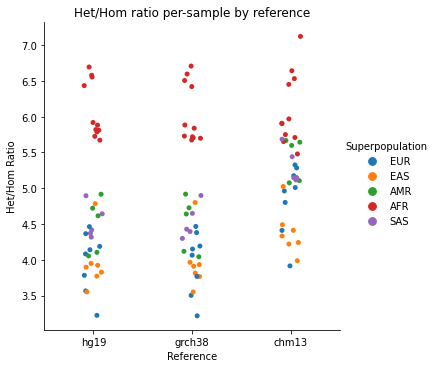

count  mean  std  min  25%  50%  75%   max
reference svtype                                            
chm13     DEL     36.00  3.93 0.49 2.94 3.72 3.95 4.22  5.08
          INS     36.00  7.48 1.38 4.89 6.61 7.30 8.15 10.79
          TOT     36.00  5.29 0.76 3.91 4.92 5.23 5.69  7.12
grch38    DEL     36.00  3.10 0.56 2.25 2.74 2.95 3.70  4.14
          INS     36.00  6.51 1.61 3.91 5.28 6.03 7.79  9.81
          TOT     36.00  4.75 0.97 3.22 4.02 4.45 5.70  6.71
hg19      DEL     36.00  3.10 0.57 2.26 2.73 2.94 3.74  4.14
          INS     36.00  6.54 1.64 3.92 5.33 6.02 7.89  9.87
          TOT     36.00  4.76 0.98 3.22 4.03 4.44 5.74  6.69

In [6]:
exact_data = data[(data["merge"] == "exact")]

display(Markdown("# Exact Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
exact_sv_counts = plot_sv_counts(exact_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
exact_sz_counts = plot_svsize_counts(exact_data)
display(Markdown("## SV HET/HOM Ratios"))
exact_gt_counts = plot_hethom_stats(exact_data)

# Loose Merging - Per-Sample Stats

## SVCounts per-sample

['AFR', 'AMR', 'EAS', 'EUR', 'SAS']


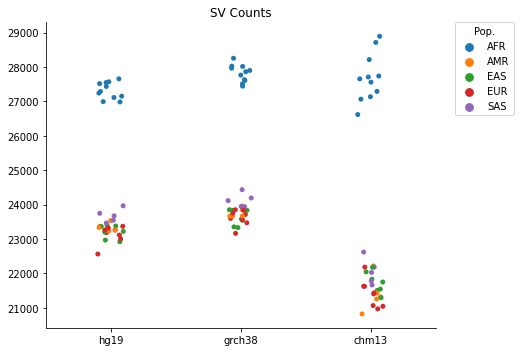

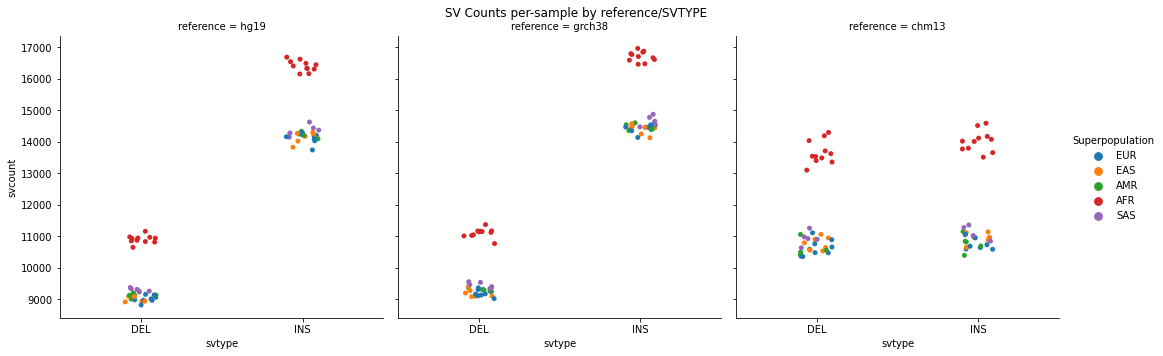

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 23,484 2,879 20,823 21,434 21,931 27,084 28,894
grch38         36 24,993 1,919 23,165 23,665 23,852 27,538 28,256
hg19           36 24,533 1,893 22,564 23,253 23,387 27,025 27,657

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 11,632 1,398 10,359 10,584 10,916 13,372 14,301
          INS         36 11,852 1,486 10,397 10,837 11,037 13,689 14,593
grch38    DEL         36  9,831   870  9,023  9,194  9,360 11,018 11,374
          INS         36 15,162 1,055 14,131 14,459 14,544 16,511 16,970
hg19      DEL         36  9,656   852  8,820  9,051  9,198 10,822 11,162
          INS         36 14,877 1,048 13,744 14,176 14,278 16,205 16,693

## SVCounts by SZBIN per-sample

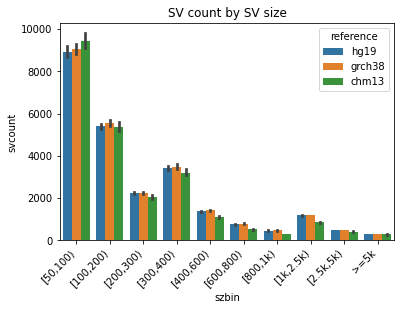

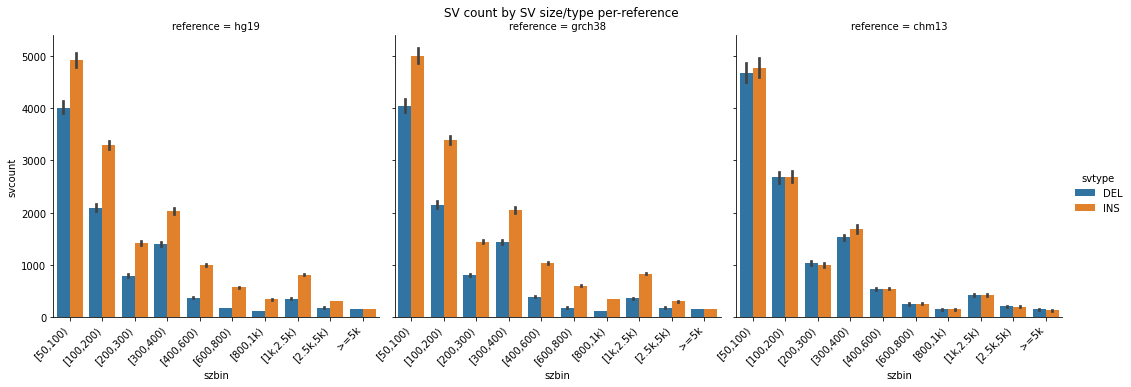

svcount                                            
                      count  mean   std   min   25%   50%    75%    max
reference szbin                                                        
chm13     [50,100)       36 9,431 1,137 8,390 8,655 8,788 10,882 11,428
          [100,200)      36 5,365   661 4,741 4,893 5,006  6,160  6,615
          [200,300)      36 2,042   242 1,771 1,870 1,922  2,313  2,573
          [300,400)      36 3,206   445 2,799 2,876 2,971  3,724  4,173
          [400,600)      36 1,086   118   906 1,010 1,044  1,227  1,303
          [600,800)      36   512    73   424   460   482    575    697
          [800,1k)       36   307    36   253   282   298    340    385
          [1k,2.5k)      36   846   108   731   765   800    968  1,033
          [2.5k,5k)      36   406    53   343   366   392    459    513
          >=5k           36   282    36   225   256   272    316    345
grch38    [50,100)       36 9,039   781 8,315 8,500 8,602 10,100 10,364
          [100,200)      36 5,545   426 5,109 5,239 5,332  6,124  6,261
          [200,300)      36 2,254   157 2,027 2,152 2,192  2,421  2,542
          [300,400)      36 3,488   304 3,210 3,272 3,310  3,894  4,064
          [400,600)      36 1,428    73 1,325 1,372 1,412  1,484  1,580
          [600,800)      36   780    49   719   739   769    823    879
          [800,1k)       36   468    33   431   443   456    487    544
          [1k,2.5k)      36 1,194    76 1,096 1,138 1,166  1,287  1,335
          [2.5k,5k)      36   487    40   424   460   476    510    584
          >=5k           36   310    25   261   294   304    323    359
hg19      [50,100)       36 8,929   772 8,227 8,390 8,510 10,015 10,235
          [100,200)      36 5,389   417 4,907 5,099 5,176  5,952  6,095
          [200,300)      36 2,216   156 1,997 2,108 2,152  2,380  2,494
          [300,400)      36 3,429   298 3,164 3,220 3,260  3,821  3,978
          [400,600)      36 1,378    71 1,264 1,330 1,362  1,430  1,530
          [600,800)      36   750    49   691   716   732    798    861
          [800,1k)       36   461    31   424   436   447    488    529
          [1k,2.5k)      36 1,174    78 1,068 1,116 1,150  1,256  1,322
          [2.5k,5k)      36   495    38   436   469   488    513    590
          >=5k           36   312    25   264   297   306    325    357

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,672 560 4,140 4,274 4,388 5,368 5,692
                 [100,200)      36 2,675 328 2,296 2,440 2,516 3,074 3,266
                 [200,300)      36 1,037 119   901   952   981 1,168 1,266
                 [300,400)      36 1,526 179 1,357 1,396 1,438 1,716 1,932
                 [400,600)      36   537  63   466   487   516   593   680
                 [600,800)      36   254  37   186   226   240   288   339
                 [800,1k)       36   154  20   126   139   150   169   203
                 [1k,2.5k)      36   419  63   336   370   394   482   545
                 [2.5k,5k)      36   208  31   171   183   197   238   271
                 >=5k           36   151  20   115   139   146   169   191
          INS    [50,100)       36 4,760 582 4,219 4,335 4,450 5,516 5,736
                 [100,200)      36 2,691 336 2,353 2,454 2,510 3,062 3,349
                 [200,300)      36 1,005 125   865   914   944 1,138 1,307
                 [300,400)      36 1,680 268 1,442 1,484 1,536 1,991 2,241
                 [400,600)      36   549  60   423   510   532   601   672
                 [600,800)      36   258  40   208   228   246   286   360
                 [800,1k)       36   154  19   127   140   148   172   186
                 [1k,2.5k)      36   427  47   372   391   406   473   518
                 [2.5k,5k)      36   199  25   158   175   201   218   249
                 >=5k           36   131  19   105   116   124   145   168
grch38    DEL    [50,100)       36 4,046 370 3,649 3,786 3,862 4,493 4,668
                 [100,200)      36 2,149 199 1,916 2,010 2,046 2,415 2,476
                 [200,300)      36   812  70   728   758   784   881   952
                 [300,400)      36 1,439 108 1,310 1,362 1,388 1,568 1,635
                 [400,600)      36   389  34   335   364   377   416   470
                 [600,800)      36   180  23   148   164   176   202   219
                 [800,1k)       36   119  13   100   111   118   129   150
                 [1k,2.5k)      36   361  40   313   332   344   405   446
                 [2.5k,5k)      36   181  25   150   162   170   199   234
                 >=5k           36   155  15   130   146   152   161   184
          INS    [50,100)       36 4,993 416 4,589 4,703 4,763 5,538 5,733
                 [100,200)      36 3,396 230 3,141 3,238 3,285 3,684 3,809
                 [200,300)      36 1,442  91 1,270 1,388 1,404 1,538 1,604
                 [300,400)      36 2,049 198 1,854 1,910 1,947 2,313 2,429
                 [400,600)      36 1,039  45   975 1,004 1,030 1,068 1,149
                 [600,800)      36   600  29   554   576   598   611   664
                 [800,1k)       36   350  23   316   331   346   362   409
                 [1k,2.5k)      36   834  40   779   804   824   859   930
                 [2.5k,5k)      36   306  19   265   293   304   320   363
                 >=5k           36   155  14   128   144   158   163   181
hg19      DEL    [50,100)       36 4,003 364 3,611 3,744 3,809 4,458 4,625
                 [100,200)      36 2,097 194 1,883 1,958 2,006 2,348 2,424
                 [200,300)      36   796  68   717   744   770   859   943
                 [300,400)      36 1,403 104 1,277 1,328 1,356 1,532 1,584
                 [400,600)      36   376  34   319   349   368   406   460
                 [600,800)      36   175  23   143   156   169   195   220
                 [800,1k)       36   114  10    98   107   114   122   138
                 [1k,2.5k)      36   357  43   304   323   338   408   442
                 [2.5k,5k)      36   182  23   150   164   175   200   229
                 >=5k           36   154  15   130   144   152   159   186
          INS    [50,100)       36 4,926 412 4,506 4

## SV HET/HOM Ratios

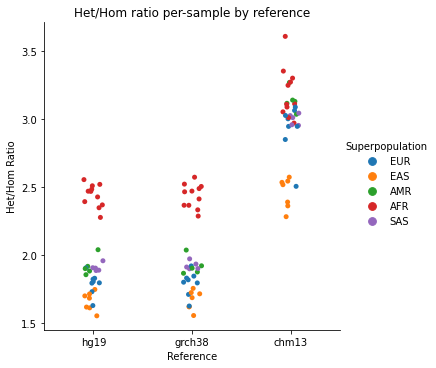

count  mean  std  min  25%  50%  75%  max
reference svtype                                           
chm13     DEL     36.00  2.77 0.28 2.12 2.74 2.83 2.93 3.28
          INS     36.00  3.16 0.34 2.43 3.09 3.21 3.33 3.97
          TOT     36.00  2.95 0.30 2.28 2.92 3.02 3.11 3.61
grch38    DEL     36.00  2.26 0.35 1.69 2.03 2.18 2.60 2.87
          INS     36.00  1.85 0.30 1.47 1.65 1.74 2.16 2.40
          TOT     36.00  2.00 0.31 1.55 1.78 1.90 2.34 2.57
hg19      DEL     36.00  2.26 0.35 1.70 2.05 2.17 2.62 2.86
          INS     36.00  1.85 0.30 1.46 1.64 1.73 2.16 2.38
          TOT     36.00  2.00 0.32 1.55 1.78 1.89 2.35 2.55

In [7]:
loose_data = data[(data["merge"] == "loose")]

display(Markdown("# Loose Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
loose_sv_counts = plot_sv_counts(loose_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
loose_sz_counts = plot_svsize_counts(loose_data)
display(Markdown("## SV HET/HOM Ratios"))
loose_gt_counts = plot_hethom_stats(loose_data)

# Summary figures
Need to take the views and put them together to make a facetgrid so that 
I can show merging strategy's effects for Counts and Het/Hom ratios

In [8]:
exact_sv_counts[0]["merge"] = "exact"
strict_sv_counts[0]["merge"] = "strict"
loose_sv_counts[0]["merge"] = "loose"
sv_counts = pd.concat([exact_sv_counts[0], strict_sv_counts[0], loose_sv_counts[0]])

exact_sv_counts[1]["merge"] = "exact"
strict_sv_counts[1]["merge"] = "strict"
loose_sv_counts[1]["merge"] = "loose"
sv_counts_byty = pd.concat([exact_sv_counts[1], strict_sv_counts[1], loose_sv_counts[1]])

In [17]:
print(sv_counts.groupby(['reference', 'merge'])['svcount'].mean())
print(27187 - 26668, 27187 - 24336)

reference  merge 
chm13      exact     25377.361111
           loose     23484.388889
           strict    24422.888889
grch38     exact     28345.805556
           loose     24992.694444
           strict    26533.500000
hg19       exact     27840.694444
           loose     24533.138889
           strict    26048.500000
Name: svcount, dtype: float64
519 2851


In [44]:
sv_counts_byty.groupby(['reference', 'merge', 'svtype'])['svcount'].mean().reset_index().groupby(['reference', 'svtype']).mean()

svcount
reference svtype              
chm13     DEL     11977.407407
          INS     12450.805556
grch38    DEL     10105.435185
          INS     16518.564815
hg19      DEL      9924.990741
          INS     16215.787037

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_140/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


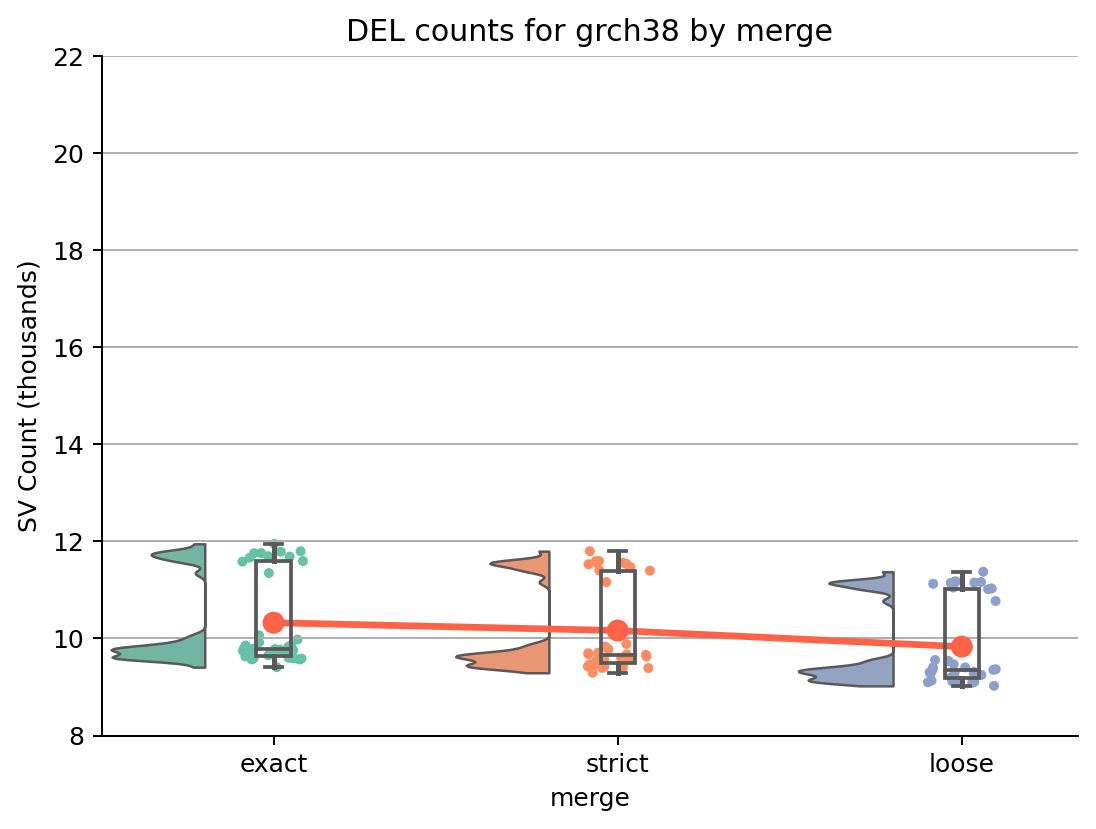

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_140/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


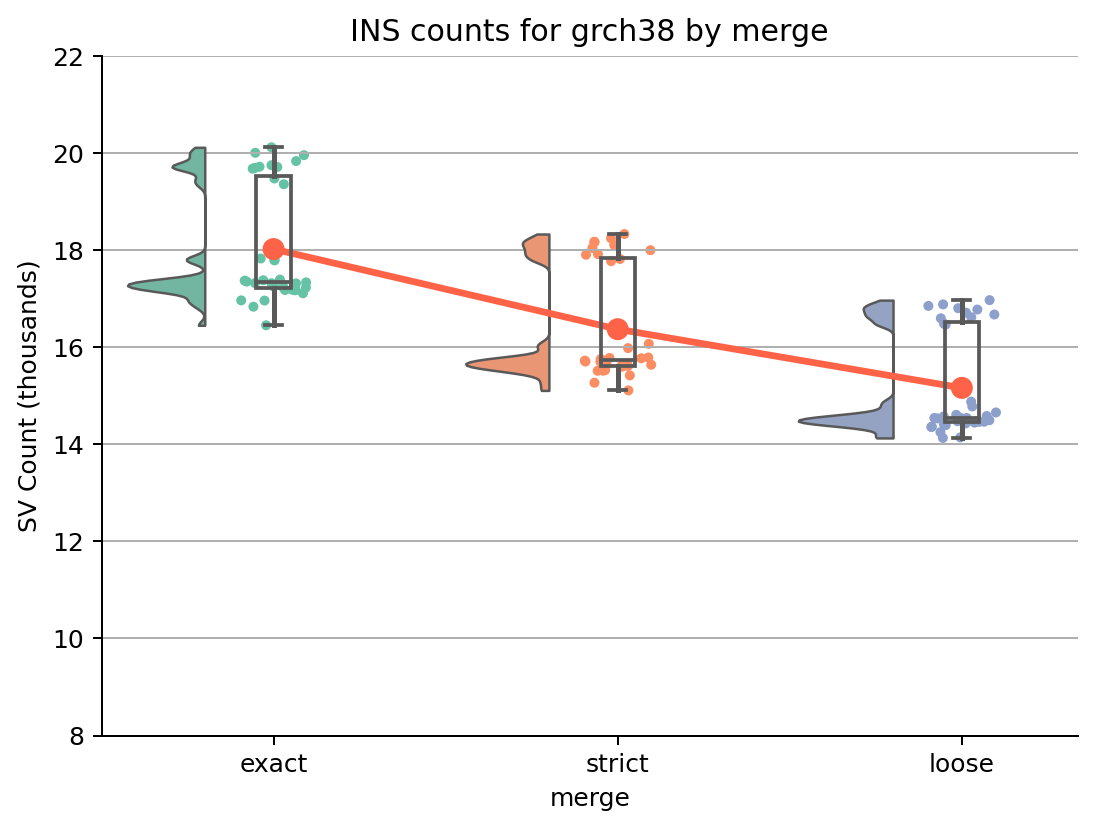

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_140/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


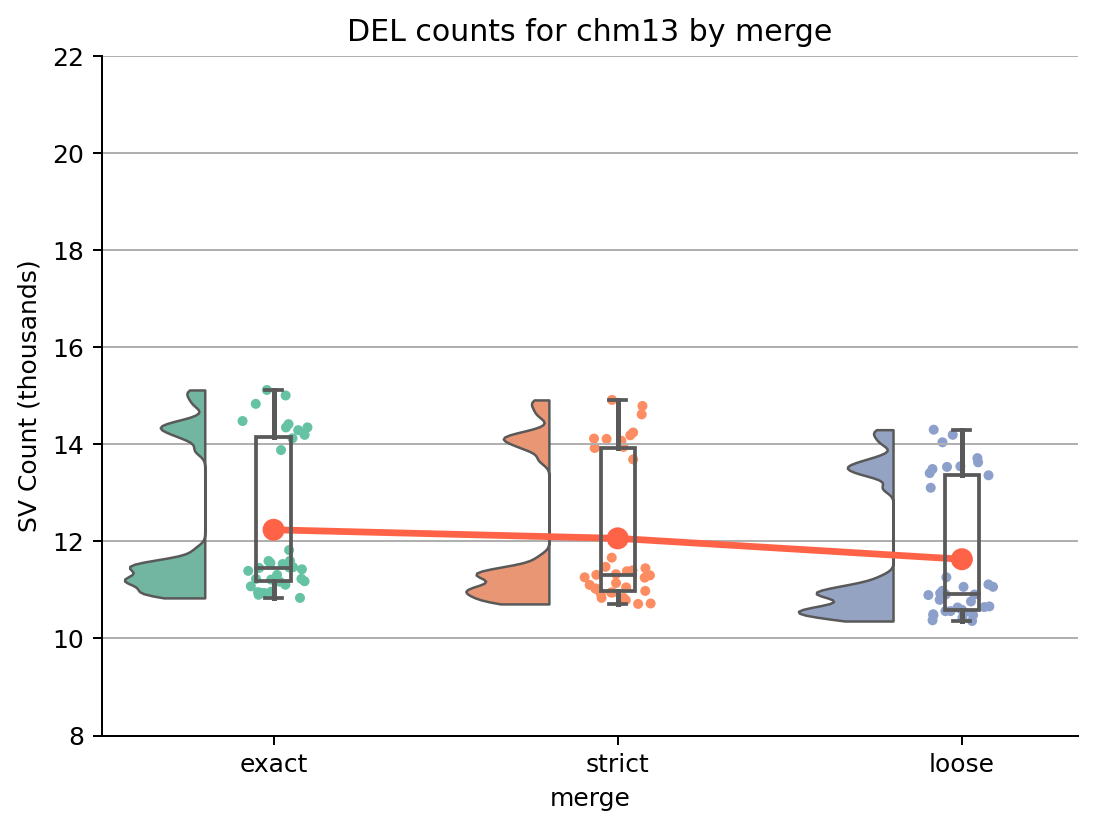

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_140/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


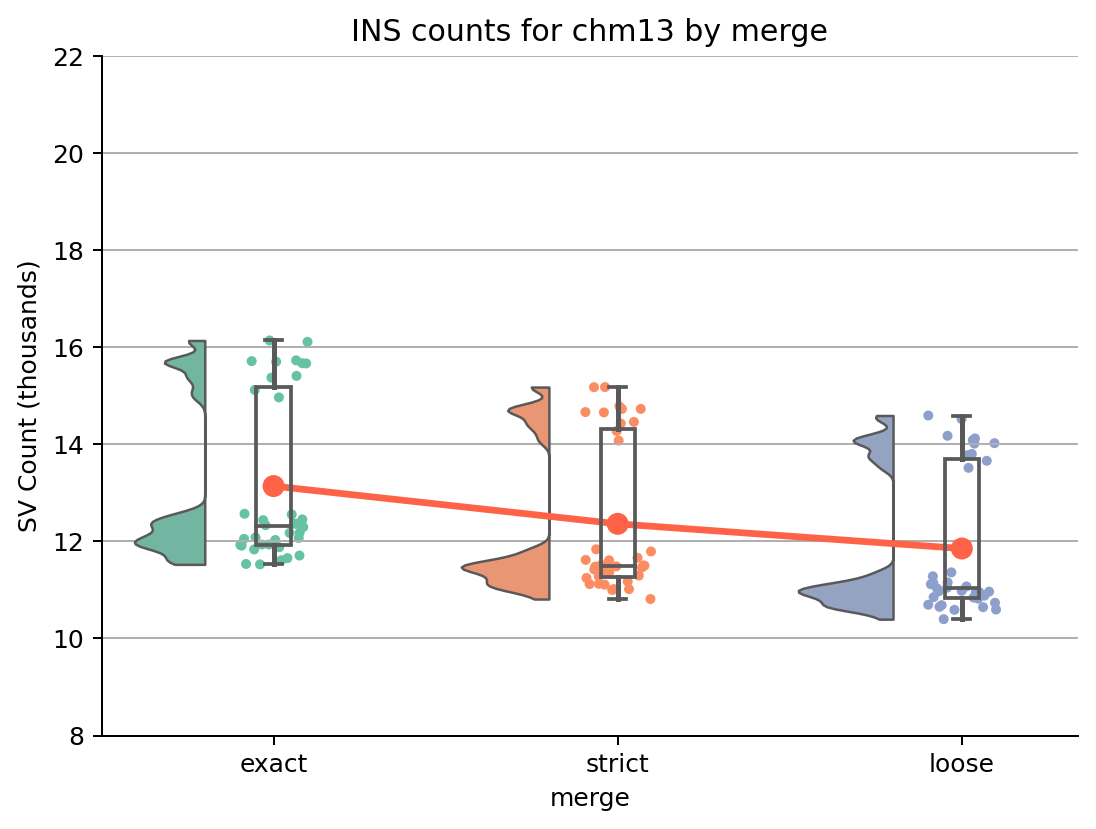

In [45]:
import ptitprince as pt
import matplotlib.pyplot as plt

# Changing orientation
dx="merge"; dy="svcount"; ort="v"; pal = "Set2"; sigma = .07
for ref in ['grch38', 'chm13']:
    for svtype in ['DEL', 'INS']:
        f, ax = plt.subplots(figsize=(7, 5), dpi=180)
        df = sv_counts_byty[(sv_counts_byty["svtype"] == svtype) 
                            & (sv_counts_byty['reference'] == ref)]
        ax=pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
                         width_viol = .55, width_box=0.10, point_size=4, move=0, jitter=1,
                        ax = ax, orient = ort, pointplot=True, linecolor='tomato')
        plt.title(f"{svtype} counts for {ref} by merge")
        ax.set_ylim(8000, 22000)
        sb.despine()
        plt.grid(which='major', axis='y')
        ax.set_axisbelow(True)
        ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])
        ax.set_ylabel("SV Count (thousands)")
        plt.show()


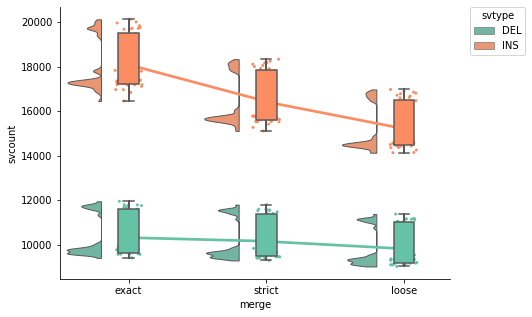

In [46]:
f, ax = plt.subplots(figsize=(7, 5))
df = sv_counts_byty[(sv_counts_byty['reference'] == 'grch38')]
ax=pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
                 width_viol = .5, ax = ax, orient = ort, pointplot=True, linecolor='blue', hue="svtype")
#plt.title(f"{svtype} counts for {ref} by merge")
sb.despine()
plt.show()

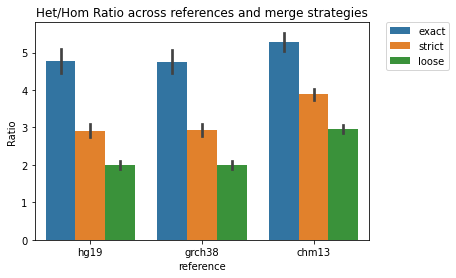

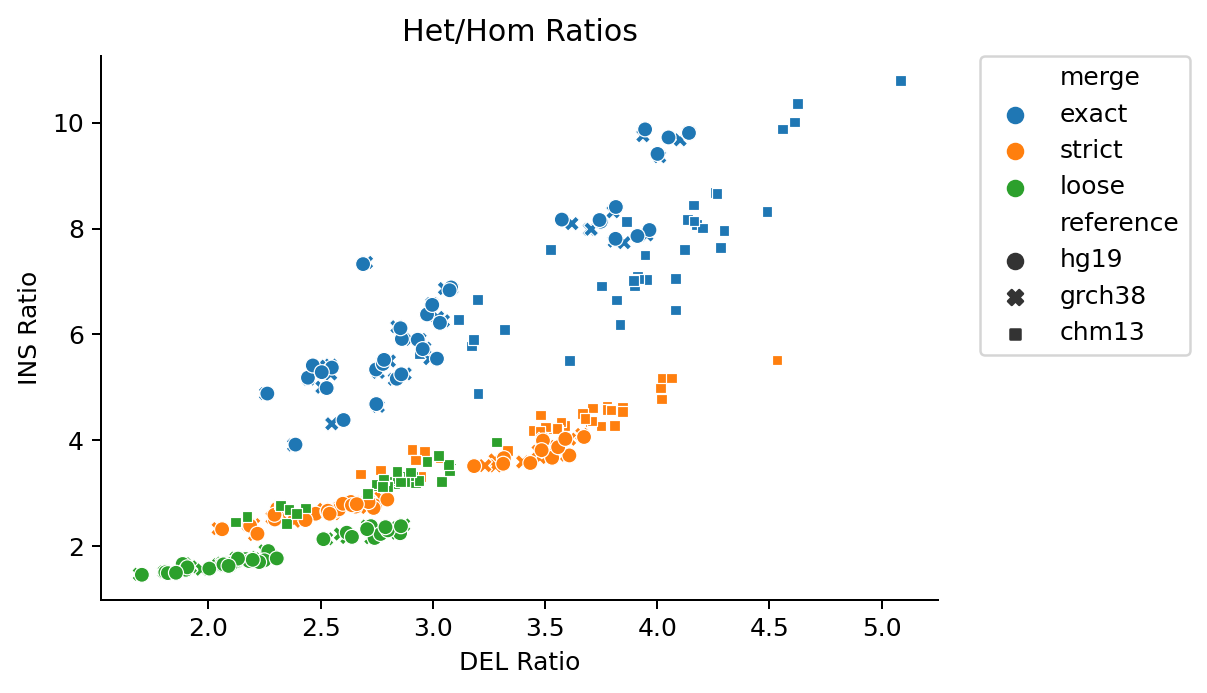

In [48]:
view = []
for name, big_df in [("exact", exact_gt_counts), ("strict", strict_gt_counts), ("loose", loose_gt_counts)]:
    for i, d in big_df.groupby(["reference", "sample", "Superpopulation"]):
        d.set_index("svtype", inplace=True)
        view.append([*i, name, d.loc["DEL"].Ratio, d.loc["INS"].Ratio, d.loc["TOT"].Ratio])
view = pd.DataFrame(view, columns=["reference", 
                                   "sample", 
                                   "Superpopulation", 
                                   "merge", 
                                   "DEL Ratio", 
                                   "INS Ratio", 
                                   "Ratio"])
p = sb.barplot(data=view, x="reference", hue="merge", y="Ratio", order=ref_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio across references and merge strategies")
plt.show()
plt.figure(dpi=180)
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="merge", 
                   style="reference", 
                   markers=True,
                  style_order=ref_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sb.despine()
hide = p.set(title="Het/Hom Ratios")

In [50]:
view.groupby('merge')["Ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
merge,,,,,,,,
exact,108.0,4.933817,0.935595,3.215846,4.147621,4.800934,5.706362,7.123627
loose,108.0,2.316460,0.548538,1.551597,1.839910,2.338455,2.872003,3.606160
strict,108.0,3.240801,0.678238,2.214728,2.629245,3.183616,3.850482,4.992877


In [53]:
len(data['sample'].unique())

36

# Scratch space

import random
import numpy as np
successes = 0
ppl = 5
trials = 1000000
n_days = 365
for _ in range(trials):
    bdays = []
    for x in range(ppl):
        bdays.append(random.randint(0, n_days))
    days = np.array(bdays)
    early = min(days)
    late = max(days)
    if late - early <= 31:
        successes += 1
print(successes, trials, successes / trials)


In [7]:
import numpy as np
x = np.array([2, 4, 5])


2

In [26]:
def merge_strategy_plots(m_data, m_data_byty, reference="grch38"):
    is_ref = m_data["reference"] == reference
    ax = sb.violinplot(data=m_data[is_ref], x="merge", y="svcount", color='gray')
    plt.setp(ax.collections, alpha=.3)
    p = sb.swarmplot(data=m_data[is_ref], x="merge", y="svcount", hue="Superpopulation")
    hide = p.set(title=f"SVCounts by Merge Strategy ({reference})", ylim=(19000, 35000))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Pop")
    plt.show()
    p = sb.violinplot(data=m_data_byty[m_data_byty["reference"] == reference], x="merge", y="svcount", hue="svtype")
    hide = p.set(title=f"SVCounts by Merge ({reference})", ylim=(7000, 22000), xlabel="", ylabel="")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="svtype")
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
    p.set_yticklabels(ylabels)
    plt.show()
    

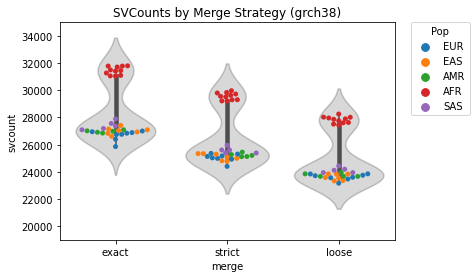

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_74385/3080018851.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


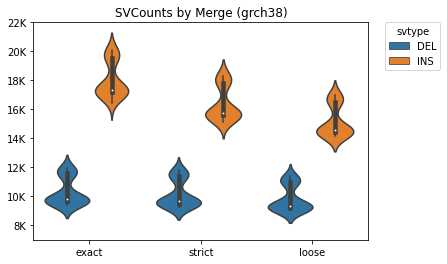

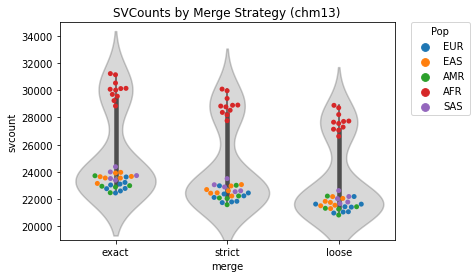

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_74385/3080018851.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


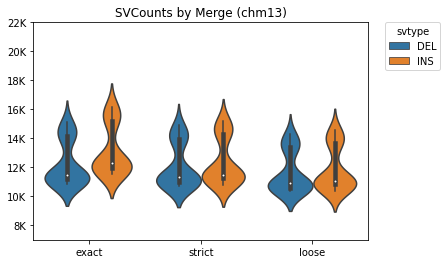

In [27]:
#merge_strategy_plots(sv_counts, sv_counts_byty, "hg19")
merge_strategy_plots(sv_counts, sv_counts_byty, "grch38")
merge_strategy_plots(sv_counts, sv_counts_byty, "chm13")
#merge_strategy_plots(sv_counts, sv_counts_byty, "pr1")


# Het/Hom Ratios per-sample

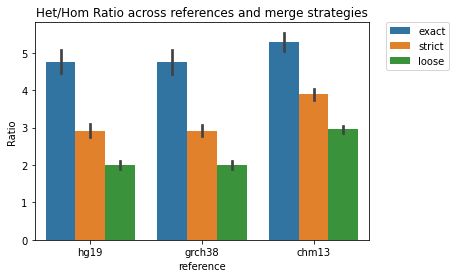

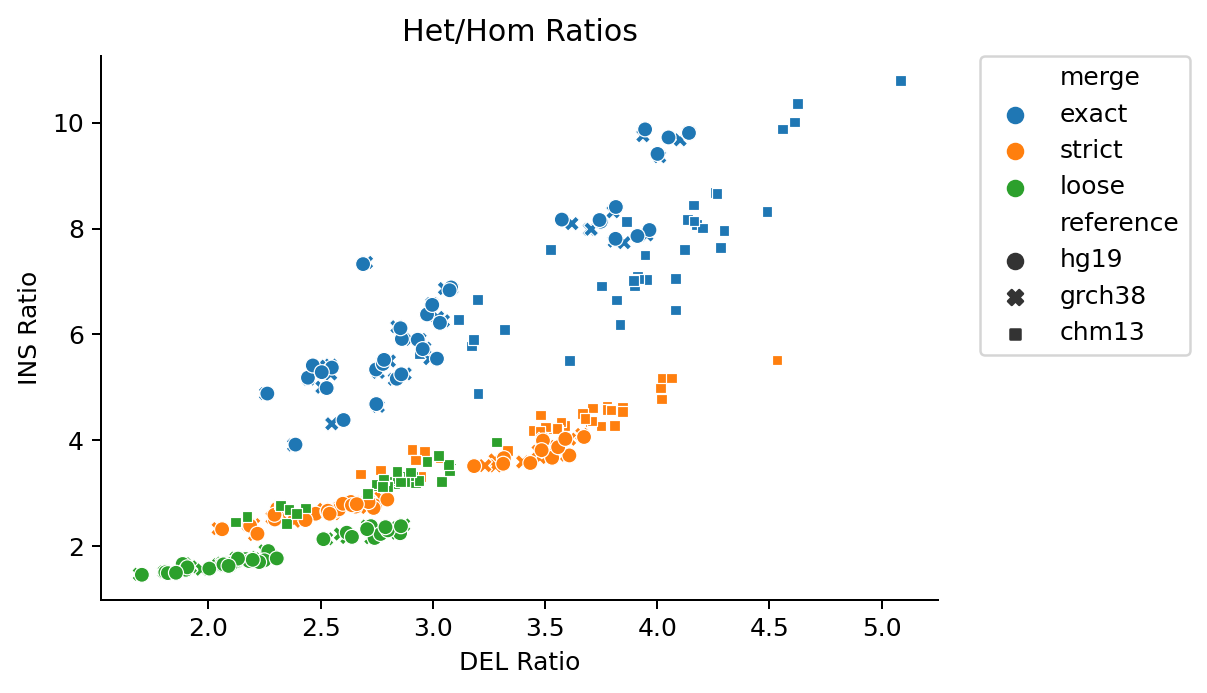

In [31]:
view["isAFR"] = view["Superpopulation"] == "AFR"

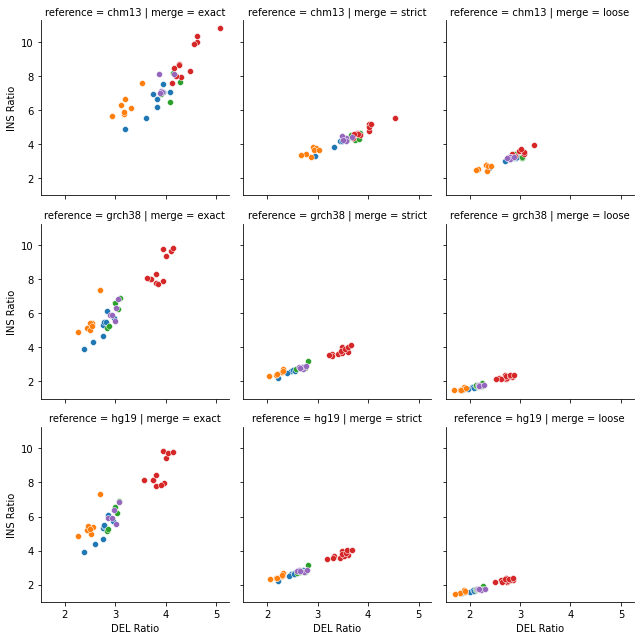

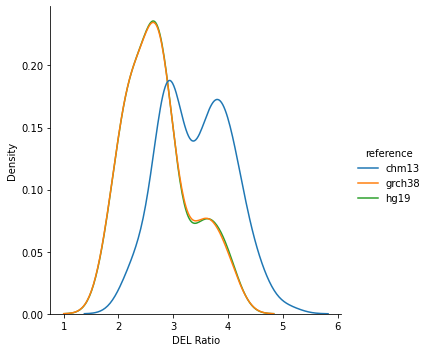

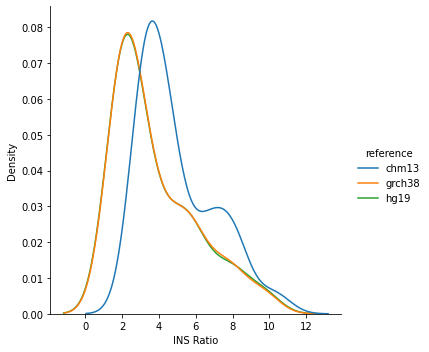

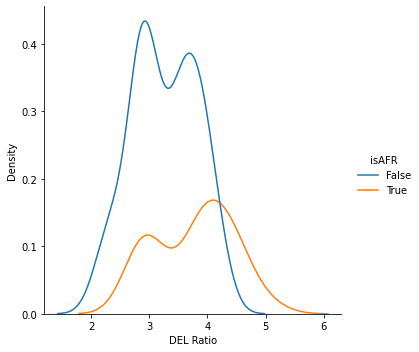

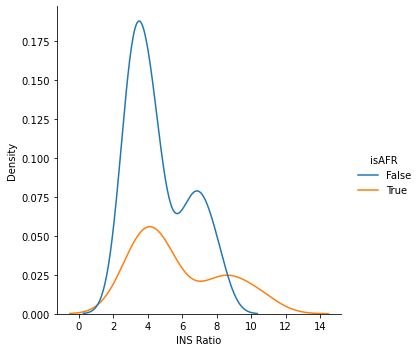

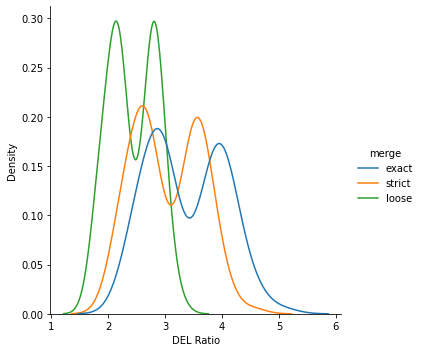

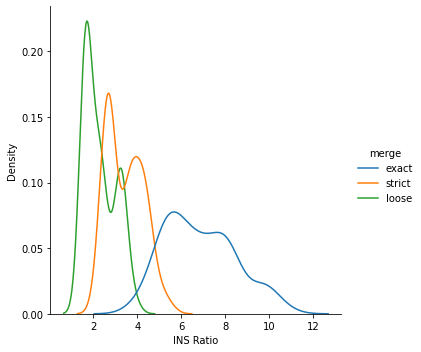

In [32]:
f = sb.FacetGrid(view, row="reference", col="merge", hue="Superpopulation")
f.map(sb.scatterplot, "DEL Ratio", "INS Ratio")
plt.show()
sb.displot(data=view, x="DEL Ratio", hue="reference", kind="kde")
plt.show()
sb.displot(data=view, x="INS Ratio", hue="reference", kind="kde")
plt.show()
sb.displot(data=view[view["reference"] == 'chm13'], x="DEL Ratio", hue="isAFR", kind="kde")
plt.show()
sb.displot(data=view[view["reference"] == 'chm13'], x="INS Ratio", hue="isAFR", kind="kde")
plt.show()
sb.displot(data=view, x="DEL Ratio", hue="merge", kind="kde")
plt.show()
sb.displot(data=view, x="INS Ratio", hue="merge", kind="kde")
plt.show()

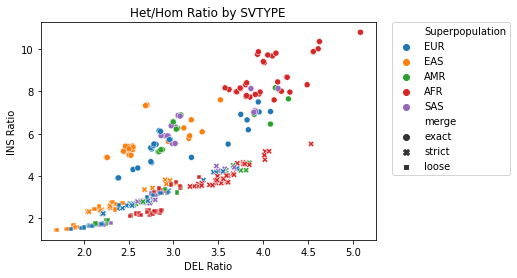

In [33]:
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="Superpopulation", 
                   style="merge", 
                   markers=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio by SVTYPE")

In [34]:
view.groupby(["reference", "merge"]).mean().applymap("{0:.2f}".format).T

reference chm13              grch38               hg19             
merge     exact loose strict  exact loose strict exact loose strict
DEL Ratio  3.93  2.77   3.54   3.10  2.26   2.79  3.10  2.26   2.80
INS Ratio  7.48  3.16   4.28   6.51  1.85   3.01  6.54  1.85   3.00
Ratio      5.29  2.95   3.89   4.75  2.00   2.92  4.76  2.00   2.92
isAFR      0.31  0.31   0.31   0.31  0.31   0.31  0.31  0.31   0.31

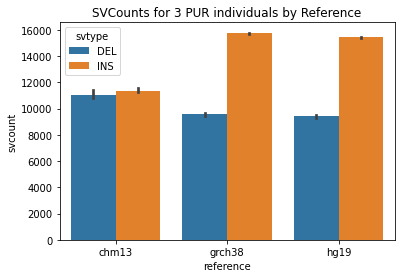

In [35]:
use_type = 1
a = strict_sv_counts[use_type].copy()
a["Population"] = metadata.loc[strict_sv_counts[use_type]["sample"]]["Population code"].reset_index(drop=True)
p = sb.barplot(data=a[a["Population"] == "PUR"], x="reference", y="svcount", hue="svtype")
hide = p.set(title="SVCounts for 3 PUR individuals by Reference")